## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2020-03-24 17:13:05--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.76.62
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.76.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.6’

train-test-data.zip 100%[===================>] 322.93M  64.6MB/s    in 4.9s    

2020-03-24 17:13:10 (66.4 MB/s) - ‘/data/train-test-data.zip.6’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.1)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.2)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0.3)
  (conv4): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop4): Dropout(p=0.4)
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop5): Dropout(p=0.5)
  (fc1): Linear(in_features=18432, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=Tru

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = composed = transforms.Compose([Rescale(250),
                                                RandomCrop(224),
                                                Normalize(),
                                                ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [8]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [10]:
#load model on cpu inspired from https://discuss.pytorch.org/t/on-a-cpu-device-how-to-load-checkpoint-saved-on-gpu-device/349

# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

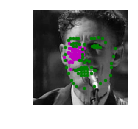

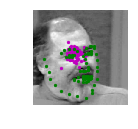

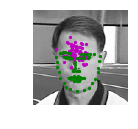

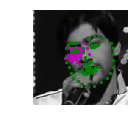

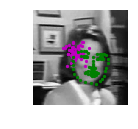

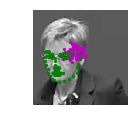

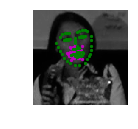

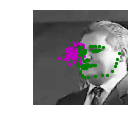

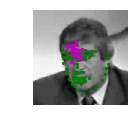

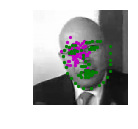

In [12]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [13]:
## TODO: Define the loss and optimization
import torch.optim as optim

# criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss()
#tried MSELoss => loss value after 10 ep = not good enough
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [14]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [ ]:
# train your network
n_epochs = 20 # start small, and increase when you've decided on your model structure and hyperparams

#!!!!!!!!!!!!!!!!
#Because the training on workspace is so slow I have trained locally on my GPU and uploaded the model
#!!!!!!!!!!!!!!!

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.2154053956270218
Epoch: 1, Batch: 20, Avg. Loss: 0.12376215383410454
Epoch: 1, Batch: 30, Avg. Loss: 0.12392556667327881
Epoch: 1, Batch: 40, Avg. Loss: 0.10117195397615433
Epoch: 1, Batch: 50, Avg. Loss: 0.09865180477499962
Epoch: 1, Batch: 60, Avg. Loss: 0.10892801061272621
Epoch: 1, Batch: 70, Avg. Loss: 0.0959315299987793
Epoch: 1, Batch: 80, Avg. Loss: 0.09729224517941475
Epoch: 1, Batch: 90, Avg. Loss: 0.1005465667694807
Epoch: 1, Batch: 100, Avg. Loss: 0.11858921498060226
Epoch: 1, Batch: 110, Avg. Loss: 0.11133004613220691
Epoch: 1, Batch: 120, Avg. Loss: 0.12456870749592781
Epoch: 1, Batch: 130, Avg. Loss: 0.11060444377362728
Epoch: 1, Batch: 140, Avg. Loss: 0.12127999514341355
Epoch: 1, Batch: 150, Avg. Loss: 0.09725112244486808
Epoch: 1, Batch: 160, Avg. Loss: 0.09541897363960743
Epoch: 1, Batch: 170, Avg. Loss: 0.10905198231339455
Epoch: 1, Batch: 180, Avg. Loss: 0.09473691284656524
Epoch: 1, Batch: 190, Avg. Loss: 0.0942695528268814
Epoch:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.09116759859025478
Epoch: 2, Batch: 20, Avg. Loss: 0.07349705621600151
Epoch: 2, Batch: 30, Avg. Loss: 0.10240850485861301
Epoch: 2, Batch: 40, Avg. Loss: 0.09386114552617073
Epoch: 2, Batch: 50, Avg. Loss: 0.08183215036988259
Epoch: 2, Batch: 60, Avg. Loss: 0.08380146659910678
Epoch: 2, Batch: 70, Avg. Loss: 0.1044335663318634
Epoch: 2, Batch: 80, Avg. Loss: 0.0936478041112423
Epoch: 2, Batch: 90, Avg. Loss: 0.1133967898786068
Epoch: 2, Batch: 100, Avg. Loss: 0.09045719504356384
Epoch: 2, Batch: 110, Avg. Loss: 0.08447071872651576
Epoch: 2, Batch: 120, Avg. Loss: 0.0842365488409996
Epoch: 2, Batch: 130, Avg. Loss: 0.10193601511418819
Epoch: 2, Batch: 140, Avg. Loss: 0.10706457868218422
Epoch: 2, Batch: 150, Avg. Loss: 0.10390356704592704
Epoch: 2, Batch: 160, Avg. Loss: 0.1132614403963089
Epoch: 2, Batch: 170, Avg. Loss: 0.07582249231636524
Epoch: 2, Batch: 180, Avg. Loss: 0.10733248740434646
Epoch: 2, Batch: 190, Avg. Loss: 0.10648395642638206
Epoch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.08593476898968219
Epoch: 3, Batch: 20, Avg. Loss: 0.0736309252679348
Epoch: 3, Batch: 30, Avg. Loss: 0.09915321543812752
Epoch: 3, Batch: 40, Avg. Loss: 0.09877663105726242
Epoch: 3, Batch: 50, Avg. Loss: 0.08448090255260468
Epoch: 3, Batch: 60, Avg. Loss: 0.07913763709366321
Epoch: 3, Batch: 70, Avg. Loss: 0.08655303157866001
Epoch: 3, Batch: 80, Avg. Loss: 0.08140031844377518
Epoch: 3, Batch: 90, Avg. Loss: 0.09660296291112899
Epoch: 3, Batch: 100, Avg. Loss: 0.08547687046229839
Epoch: 3, Batch: 110, Avg. Loss: 0.0909490618854761
Epoch: 3, Batch: 120, Avg. Loss: 0.08034806624054909
Epoch: 3, Batch: 130, Avg. Loss: 0.09718185849487782
Epoch: 3, Batch: 140, Avg. Loss: 0.1035672202706337
Epoch: 3, Batch: 150, Avg. Loss: 0.10956383869051933
Epoch: 3, Batch: 160, Avg. Loss: 0.08804401569068432
Epoch: 3, Batch: 170, Avg. Loss: 0.08703637793660164
Epoch: 3, Batch: 180, Avg. Loss: 0.0799533884972334
Epoch: 3, Batch: 190, Avg. Loss: 0.09321350678801536
Epoch:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.10602064691483974
Epoch: 4, Batch: 20, Avg. Loss: 0.07047375030815602
Epoch: 4, Batch: 30, Avg. Loss: 0.08307416886091232
Epoch: 4, Batch: 40, Avg. Loss: 0.1191547229886055
Epoch: 4, Batch: 50, Avg. Loss: 0.08580558188259602
Epoch: 4, Batch: 60, Avg. Loss: 0.1081237904727459
Epoch: 4, Batch: 70, Avg. Loss: 0.08160296306014062
Epoch: 4, Batch: 80, Avg. Loss: 0.08404871709644794
Epoch: 4, Batch: 90, Avg. Loss: 0.08177252672612667
Epoch: 4, Batch: 100, Avg. Loss: 0.0832527831196785
Epoch: 4, Batch: 110, Avg. Loss: 0.09051272757351399
Epoch: 4, Batch: 120, Avg. Loss: 0.08613088391721249
Epoch: 4, Batch: 130, Avg. Loss: 0.09947722777724266
Epoch: 4, Batch: 140, Avg. Loss: 0.08854851573705673
Epoch: 4, Batch: 150, Avg. Loss: 0.09169569686055183
Epoch: 4, Batch: 160, Avg. Loss: 0.07943069078028202
Epoch: 4, Batch: 170, Avg. Loss: 0.07834410108625889
Epoch: 4, Batch: 180, Avg. Loss: 0.0845993310213089
Epoch: 4, Batch: 190, Avg. Loss: 0.09232424050569535
Epoch:

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.090986368060112
Epoch: 5, Batch: 20, Avg. Loss: 0.06933400928974151
Epoch: 5, Batch: 30, Avg. Loss: 0.09167044125497341
Epoch: 5, Batch: 40, Avg. Loss: 0.09372660890221596
Epoch: 5, Batch: 50, Avg. Loss: 0.09912884384393691
Epoch: 5, Batch: 60, Avg. Loss: 0.08760065883398056
Epoch: 5, Batch: 70, Avg. Loss: 0.08205911666154861
Epoch: 5, Batch: 80, Avg. Loss: 0.0910289503633976
Epoch: 5, Batch: 90, Avg. Loss: 0.07584742046892642
Epoch: 5, Batch: 100, Avg. Loss: 0.1112030040472746
Epoch: 5, Batch: 110, Avg. Loss: 0.09177432358264923
Epoch: 5, Batch: 120, Avg. Loss: 0.08201309628784656
Epoch: 5, Batch: 130, Avg. Loss: 0.09702608548104763
Epoch: 5, Batch: 140, Avg. Loss: 0.0811166599392891
Epoch: 5, Batch: 150, Avg. Loss: 0.07857105508446693
Epoch: 5, Batch: 160, Avg. Loss: 0.09289828911423684
Epoch: 5, Batch: 170, Avg. Loss: 0.09328979775309562
Epoch: 5, Batch: 180, Avg. Loss: 0.07727041840553284
Epoch: 5, Batch: 190, Avg. Loss: 0.08329472430050373
Epoch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.07500559911131859
Epoch: 6, Batch: 20, Avg. Loss: 0.07606805637478828
Epoch: 6, Batch: 30, Avg. Loss: 0.08385040983557701
Epoch: 6, Batch: 40, Avg. Loss: 0.0771448228508234
Epoch: 6, Batch: 50, Avg. Loss: 0.08074920102953911
Epoch: 6, Batch: 60, Avg. Loss: 0.09771271347999573
Epoch: 6, Batch: 70, Avg. Loss: 0.09467939436435699
Epoch: 6, Batch: 80, Avg. Loss: 0.08677721731364726
Epoch: 6, Batch: 90, Avg. Loss: 0.09467963688075542
Epoch: 6, Batch: 100, Avg. Loss: 0.08747539855539799
Epoch: 6, Batch: 110, Avg. Loss: 0.09155371524393559
Epoch: 6, Batch: 120, Avg. Loss: 0.10412363111972808
Epoch: 6, Batch: 130, Avg. Loss: 0.09229419454932213
Epoch: 6, Batch: 140, Avg. Loss: 0.10818510800600052
Epoch: 6, Batch: 150, Avg. Loss: 0.100161874294281
Epoch: 6, Batch: 160, Avg. Loss: 0.07655457817018033
Epoch: 6, Batch: 170, Avg. Loss: 0.07068306934088468
Epoch: 6, Batch: 180, Avg. Loss: 0.09684384763240814
Epoch: 6, Batch: 190, Avg. Loss: 0.08337298035621643
Epoch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.1126637578010559
Epoch: 7, Batch: 20, Avg. Loss: 0.07204241193830967
Epoch: 7, Batch: 30, Avg. Loss: 0.08872710838913918
Epoch: 7, Batch: 40, Avg. Loss: 0.10213147364556789
Epoch: 7, Batch: 50, Avg. Loss: 0.09484394788742065
Epoch: 7, Batch: 60, Avg. Loss: 0.0847710870206356
Epoch: 7, Batch: 70, Avg. Loss: 0.08490328080952167
Epoch: 7, Batch: 80, Avg. Loss: 0.0996139906346798
Epoch: 7, Batch: 90, Avg. Loss: 0.1105924516916275
Epoch: 7, Batch: 100, Avg. Loss: 0.09766244366765023
Epoch: 7, Batch: 110, Avg. Loss: 0.07173932380974293
Epoch: 7, Batch: 120, Avg. Loss: 0.08558710291981697
Epoch: 7, Batch: 130, Avg. Loss: 0.09231393001973628
Epoch: 7, Batch: 140, Avg. Loss: 0.09545115418732167
Epoch: 7, Batch: 150, Avg. Loss: 0.08803582452237606
Epoch: 7, Batch: 160, Avg. Loss: 0.08849687539041043
Epoch: 7, Batch: 170, Avg. Loss: 0.0999287199229002
Epoch: 7, Batch: 180, Avg. Loss: 0.12190973944962025
Epoch: 7, Batch: 190, Avg. Loss: 0.08393373005092145
Epoch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.0972777284681797
Epoch: 8, Batch: 20, Avg. Loss: 0.09588981084525586
Epoch: 8, Batch: 30, Avg. Loss: 0.08118420131504536
Epoch: 8, Batch: 40, Avg. Loss: 0.09880391769111156
Epoch: 8, Batch: 50, Avg. Loss: 0.08375157453119755
Epoch: 8, Batch: 60, Avg. Loss: 0.09001307152211666
Epoch: 8, Batch: 70, Avg. Loss: 0.08341540135443211
Epoch: 8, Batch: 80, Avg. Loss: 0.0871199831366539
Epoch: 8, Batch: 90, Avg. Loss: 0.11307659931480885
Epoch: 8, Batch: 100, Avg. Loss: 0.07318054512143135
Epoch: 8, Batch: 110, Avg. Loss: 0.08575642295181751
Epoch: 8, Batch: 120, Avg. Loss: 0.09349271580576897
Epoch: 8, Batch: 130, Avg. Loss: 0.10933357663452625
Epoch: 8, Batch: 140, Avg. Loss: 0.1021691095083952
Epoch: 8, Batch: 150, Avg. Loss: 0.09921470806002616
Epoch: 8, Batch: 160, Avg. Loss: 0.09721965342760086
Epoch: 8, Batch: 170, Avg. Loss: 0.07720019854605198
Epoch: 8, Batch: 180, Avg. Loss: 0.10028555244207382
Epoch: 8, Batch: 190, Avg. Loss: 0.07855512201786041
Epoch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.07139629721641541
Epoch: 9, Batch: 20, Avg. Loss: 0.09399706311523914
Epoch: 9, Batch: 30, Avg. Loss: 0.09425899162888526
Epoch: 9, Batch: 40, Avg. Loss: 0.1048702396452427
Epoch: 9, Batch: 50, Avg. Loss: 0.09004122689366341
Epoch: 9, Batch: 60, Avg. Loss: 0.09882954210042953
Epoch: 9, Batch: 70, Avg. Loss: 0.09348994269967079
Epoch: 9, Batch: 80, Avg. Loss: 0.0907659649848938
Epoch: 9, Batch: 90, Avg. Loss: 0.08169606178998948
Epoch: 9, Batch: 100, Avg. Loss: 0.09551477283239365
Epoch: 9, Batch: 110, Avg. Loss: 0.10024463944137096
Epoch: 9, Batch: 120, Avg. Loss: 0.08940396383404732
Epoch: 9, Batch: 130, Avg. Loss: 0.08887847661972045
Epoch: 9, Batch: 140, Avg. Loss: 0.13168372884392737
Epoch: 9, Batch: 150, Avg. Loss: 0.10546494871377946
Epoch: 9, Batch: 160, Avg. Loss: 0.08835688270628453
Epoch: 9, Batch: 170, Avg. Loss: 0.09045039974153042
Epoch: 9, Batch: 180, Avg. Loss: 0.08844157345592976
Epoch: 9, Batch: 190, Avg. Loss: 0.0983363550156355
Epoch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.10125006884336471
Epoch: 10, Batch: 20, Avg. Loss: 0.07481163442134857
Epoch: 10, Batch: 30, Avg. Loss: 0.10430046580731869
Epoch: 10, Batch: 40, Avg. Loss: 0.09133522398769855
Epoch: 10, Batch: 50, Avg. Loss: 0.09255004562437534
Epoch: 10, Batch: 60, Avg. Loss: 0.09764757491648197
Epoch: 10, Batch: 70, Avg. Loss: 0.09738977104425431
Epoch: 10, Batch: 80, Avg. Loss: 0.09743493981659412
Epoch: 10, Batch: 90, Avg. Loss: 0.08704061172902584
Epoch: 10, Batch: 100, Avg. Loss: 0.06999919228255749
Epoch: 10, Batch: 110, Avg. Loss: 0.08506309911608696
Epoch: 10, Batch: 120, Avg. Loss: 0.09670107997953892
Epoch: 10, Batch: 130, Avg. Loss: 0.08468598127365112
Epoch: 10, Batch: 140, Avg. Loss: 0.08624038361012935
Epoch: 10, Batch: 150, Avg. Loss: 0.08247603699564934
Epoch: 10, Batch: 160, Avg. Loss: 0.09061610624194145
Epoch: 10, Batch: 170, Avg. Loss: 0.07968680113554001
Epoch: 10, Batch: 180, Avg. Loss: 0.09377895817160606
Epoch: 10, Batch: 190, Avg. Loss: 0.0

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 10, Avg. Loss: 0.08446034006774425
Epoch: 11, Batch: 20, Avg. Loss: 0.08291241526603699
Epoch: 11, Batch: 30, Avg. Loss: 0.09548391290009021
Epoch: 11, Batch: 40, Avg. Loss: 0.08131674751639366
Epoch: 11, Batch: 50, Avg. Loss: 0.09578886479139329
Epoch: 11, Batch: 60, Avg. Loss: 0.09494795687496663
Epoch: 11, Batch: 70, Avg. Loss: 0.10103007480502128
Epoch: 11, Batch: 80, Avg. Loss: 0.07980728037655353
Epoch: 11, Batch: 90, Avg. Loss: 0.11517464891076087
Epoch: 11, Batch: 100, Avg. Loss: 0.10618254505097866
Epoch: 11, Batch: 110, Avg. Loss: 0.0957617625594139
Epoch: 11, Batch: 120, Avg. Loss: 0.1152273915708065
Epoch: 11, Batch: 130, Avg. Loss: 0.11955340243875981
Epoch: 11, Batch: 140, Avg. Loss: 0.1027533918619156
Epoch: 11, Batch: 150, Avg. Loss: 0.06793369501829147
Epoch: 11, Batch: 160, Avg. Loss: 0.08307093903422355
Epoch: 11, Batch: 170, Avg. Loss: 0.09000882543623448
Epoch: 11, Batch: 180, Avg. Loss: 0.0824202574789524
Epoch: 11, Batch: 190, Avg. Loss: 0.08711

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [15]:
# get a sample of test data again
net = Net()
#I understood how to load the model on cpu and how to load it as model from https://stackoverflow.com/questions/48419626/pytorch-cant-load-cnn-model-and-do-prediction-typeerror-collections-orderedd
net.load_state_dict(torch.load('./saved_models/keypoints_model_Adam_SL1_NaimishNet_partial_epoch_20.pt', map_location=lambda storage, loc: storage))
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


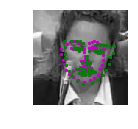

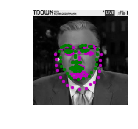

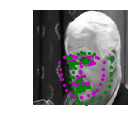

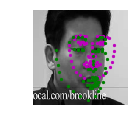

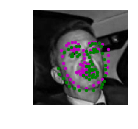

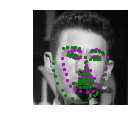

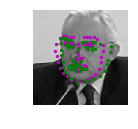

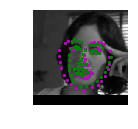

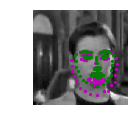

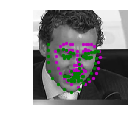

In [16]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [ ]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_Adam_SL1_NaimishNet_partial'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name+'_epoch_'+str(n_epochs) + '.pt')

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: I have looked at NaimishNet paper and I have seen they use the Adam optimizer. Also, from what I have seen on various sources, I wanted to use Ranger (which is RAdam + Lookahead) but as we had a relatively small-medium dataset it was overkill. So I wanted to use RAdam but it wasn't integrated in pytorch so I decided upon Adam.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: First I tried to a smoother architecture than NaimishNet as I thought that big kernels and big dropout probabilities could have worse effects on training the dataset. However, as I have seen that my network was stalling I decided to add more depth to it and be more compliant with NaimishNet. For Loss, I tried MSE first, but I have seen in the paper that Smoother L1 loss is used and it seemed to give better results. I decided to add dropout to avoid certain nodes to dominate the training. Data rotations might have helped (but I think with a (-45,45) degrees interval, as I think this kind of network us commonly used in more static enviroments, with static cameras facing normally (like a webcam). BN might've been a good improvement and I will try it in the future. I think the model overfitted the data a bit as it seems to try and detect facial points as if the face is not seen from an angle but mainly from the front. 

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: The batchsize was locked on 10 in the notebook workspace, as I couldn't train on GPU. So I moved locally and I have trained my network on my NVIDIA GeForce 970 with a batch size of 32. From what I have read, it is more optimal to have the batchsize as a power of 2. For training, I have trained for 20 epochs locally (I have stopped the workspace cpu training at 4 epochs) and I decided it was enough as the Loss seemed to stagnate at 0.035-0.04.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.02746794 -0.2403654  -0.07835298  0.02840238  0.23464988]
 [-0.22766666 -0.19477452  0.10295553 -0.08079665  0.05153436]
 [ 0.07843263 -0.18700872  0.11680876 -0.17783768 -0.00223843]
 [-0.14367709 -0.24087     0.17326927  0.14191101  0.06710528]
 [-0.18906631  0.1171287   0.01325736  0.12643363  0.08629069]]
(5, 5)


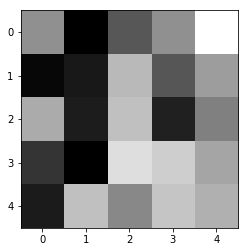

In [24]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer

weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 4

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

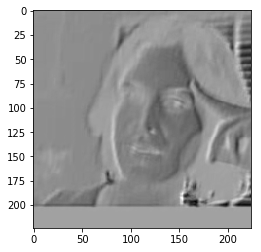

In [25]:
##TODO: load in and display any image from the transformed test dataset

import cv2

image = np.squeeze(test_images[7])

image_np = image.numpy()
image_convolved = cv2.filter2D(image_np, -1, w[filter_index][0])
#taken from
#https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html


plt.imshow(image_convolved, cmap='gray')
plt.show()
## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image


#DISCLAIMER: I have searched for errors I had on my local machine mainly on stack overflow and https://discuss.pytorch.org/.
# Some ideas I had in order to correct myself came from medium/towards data science blogposts

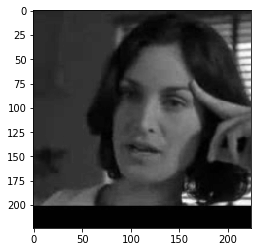

In [26]:
plt.imshow(image_np, cmap='gray')
plt.show()

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: The kernel above seems to detect vertical edges with a darker part on the left and lighter part on the right. As we can see, the transitions from left-right(darker-lighter) are shown in whiter lines, and the opposite left-right(lighter-to-darker) are shown as blacker lines. I think its purpose is to maybe separate an object from its background. 

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!